# "Anticipez les besoins en consommation électrique de bâtiments"
_Modelling Notebook_

## 0 Preliminaries

### 0.0 Importing Packages and Modules

Checking whether the notebook is on Colab or PC

In [1]:
import sys
is_colab = 'google.colab' in sys.modules
is_colab, sys.executable

(True, '/usr/bin/python3')

Mounting my Drive if on colab

In [2]:
if is_colab==True:
    from google.colab import files, output, drive
    drive.mount('/gdrive')
    %cd /gdrive
    print("You're on Google Colab")
else:
    print("You're on a PC")

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).
/gdrive
You're on Google Colab


Noticing user about files that has to be in the current working directory.

In [3]:
def file_required(file_name):
    if os.path.exists(os.getcwd()+"/"+file_name):
        print("OK, loading "+file_name+"\
                           from the current working directory ...")
    else:
        print("Please, put "+file_name+"\
                           in the current working directory")

Installations and importations required for Google Colab version.

In [4]:
# !pip freeze > requirements.txt

In [5]:
import os

if is_colab==True:
    if os.getcwd()!='/gdrive/My Drive/--DATA SCIENCE/PROJET4':
        os.chdir('My Drive/--DATA SCIENCE/PROJET4')
    !pip install -r requirements.txt
else:
    # make sure 'P4_functions.py' is in the current working directory
    file_required('/P4_functions.py')
    file_required('requirements.txt')
    !pip install -r requirements.txt

In [6]:
from P4_functions import *

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Importation of modules and packages. 

In [7]:
import io
from time import time

import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.facecolor']='w'

import warnings
warnings.filterwarnings('ignore')

# from ipywidgets import interact, interact_manual

import dill

from sklearn_pandas import DataFrameMapper

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from mlxtend.plotting import plot_pca_correlation_graph
from sklearn.inspection import permutation_importance

import category_encoders as ce

import scipy.stats as st

from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.model_selection import StratifiedKFold, ShuffleSplit
from sklearn.linear_model import *
from sklearn import metrics
from sklearn.compose import make_column_transformer

from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor
from sklearn.svm import SVR

Setting pandas display options

In [46]:
dictPdSettings = {'display.max_rows': 500, 'display.width': 100,
                    'display.max_colwidth': 500,
                    'display.float_format': lambda x: '%.2f' % x}
for k,v in dictPdSettings.items():
    pd.set_option(k,v)

To play audio text-to-speech during execution.

In [47]:
from IPython.display import Audio
from gtts import gTTS

def speak(text, lang='en'):
    with io.BytesIO() as f:
        gTTS(text=text, lang=lang).write_to_fp(f)
        f.seek(0)
        return Audio(f.read(), autoplay=True)

In [10]:
speak('Packages and modules successfully imported')

### 0.1 Importing the dataset

In [48]:
if is_colab==True:
    path_csv = 'DATA/Cleaned_data.csv' 
    # Importing database from my Drive
    print("2. Try to import in notebook from myDrive...")
else:
    path_csv = '../DATA/Cleaned_data.csv'
    # Importing database from a DATA directory
    print("2. Try to import in notebook from PC ('DATA')")

df = pd.read_csv(path_csv, sep=',', index_col='Unnamed: 0',
                 low_memory=True, encoding ='utf-8')

print("-----> importation of .csv in the notebook OK")

2. Try to import in notebook from myDrive...
-----> importation of .csv in the notebook OK


In [49]:
df['ZipCode'] = df['ZipCode'].apply(str).astype('object')
df['CouncilDistrictCode'] = df['CouncilDistrictCode'].apply(str).astype('object')

In [50]:
speak('Dataset successfully imported')

### 0.2 Overview

#### Brief description

In [51]:
df.shape

(1651, 65)

In [52]:
df.columns

Index(['OSEBuildingID', 'DataYear', 'BuildingType', 'PrimaryPropertyType', 'PropertyName',
       'TaxParcelIdentificationNumber', 'CouncilDistrictCode', 'Neighborhood', 'YearBuilt',
       'NumberofBuildings', 'NumberofFloors', 'PropertyGFATotal', 'PropertyGFAParking',
       'PropertyGFABuilding(s)', 'ListOfAllPropertyUseTypes', 'LargestPropertyUseType',
       'LargestPropertyUseTypeGFA', 'SecondLargestPropertyUseType',
       'SecondLargestPropertyUseTypeGFA', 'ThirdLargestPropertyUseType',
       'ThirdLargestPropertyUseTypeGFA', 'YearsENERGYSTARCertified', 'ENERGYSTARScore',
       'SiteEUI(kBtu/sf)', 'SiteEUIWN(kBtu/sf)', 'SourceEUI(kBtu/sf)', 'SourceEUIWN(kBtu/sf)',
       'SiteEnergyUse(kBtu)', 'SiteEnergyUseWN(kBtu)', 'SteamUse(kBtu)', 'Electricity(kWh)',
       'Electricity(kBtu)', 'NaturalGas(therms)', 'NaturalGas(kBtu)', 'OtherFuelUse(kBtu)',
       'TotalGHGEmissions', 'GHGEmissionsIntensity', 'DefaultData', 'Comments', 'ComplianceStatus',
       'Outlier', 'ZipCode', 'La

Printing total nb and percentage of null

In [53]:
print_null_pct(df)

nb of null:  2191 
pct of null:  2.0


Showing columns where there are still NaN values

In [54]:
df.isna().sum(axis=0)[df.isna().sum(axis=0)!=0]

TaxParcelIdentificationNumber       1
ENERGYSTARScore                   542
Comments                         1648
dtype: int64

#### Checking the outliers

In [55]:
sel = ['NumberofBuildings', 'NumberofFloors', 'PropertyGFATotal',
       'PropertyGFAParking', 'PropertyGFABuilding(s)','LargestPropertyUseTypeGFA',
       'SecondLargestPropertyUseTypeGFA', 'ThirdLargestPropertyUseTypeGFA',
       'BuildingAge','MeanGFAperFloor', 'ParkingGFARatio', 'NbYearsCertified',
       'ExtsurfVolRatio', 'ENERGYSTARScore']

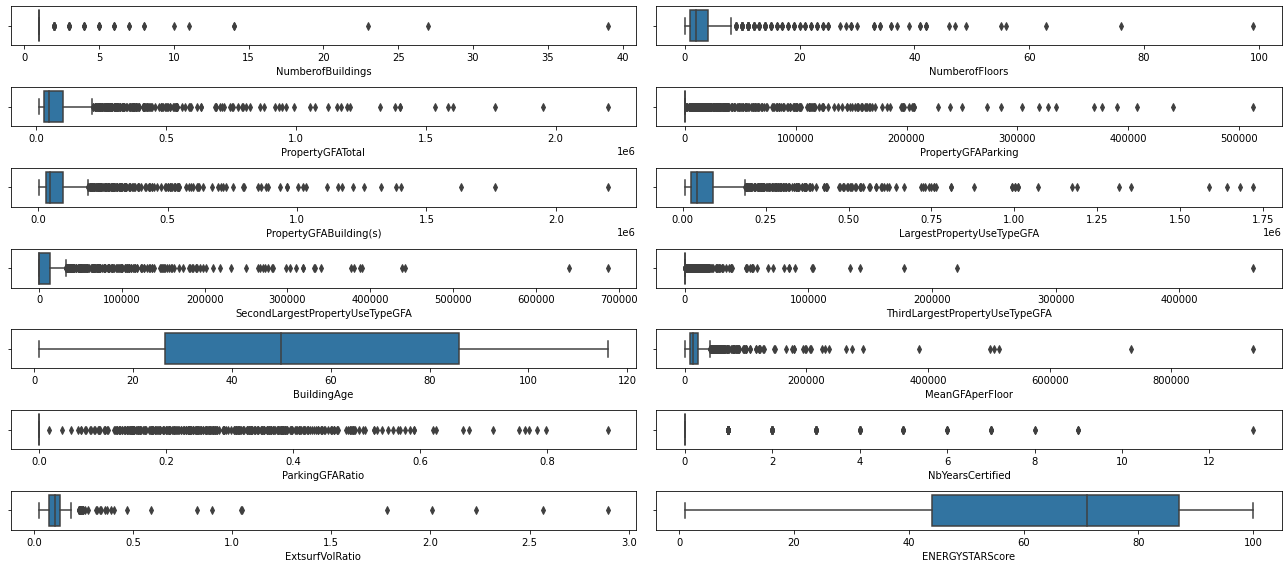

In [56]:
fig = plt.figure()
for i, c in enumerate(df[sel].columns,1):
    ax = fig.add_subplot(df[sel].shape[1]//2, 2, i)
    sns.boxplot(df[c], ax=ax)
fig.set_size_inches(18,8)
fig.tight_layout()

In [20]:
speak('Description overview done')

## 1 Data preprocessing

### 1.1 Target data transformation

We already found in the Cleaning_EDA notebook that the distribution of the target data could become almost normal with logarithmic transformation.

We'll test our models with and without this log transformation (see the 'set_dict_scv_params' function in P4_Modelling.py).

### 1.2 Feature transformation

We want to evaluate the impact of the transformation strategies for quantitative and categorical data. We'll split the columns in 4 types.

__Quantitative data__

Integers or float.

__Categorical data__

Categorical data are all nominal data, none of them are ordinal.
- Boolean : 'CertifiedPreviousYear'
- low cardinality (less than 12 categories):
'BuildingType', 'MainEnergy', 'EnergyProfile', 'Outlier'
- high cardinality (12 or more categories) :
('Neighborhood', 'LargestPropertyUseType',
 'SecondLargestPropertyUseType',
 'ThirdLargestPropertyUseType', 'PrimaryPropertyType')

The transformation of the columns is all (encoding of categorical and normalisation of quantitative) included in the Class CustTransformer (see P4_funtions.py file). The transformation options are passed to the GridSearchCV or RandomizedSearchCV through the param_grid dictionnary.

### 1.3 Outliers filtering

We detected outliers during the analysis process. We'll put in place automatic outliers filtering in the pipeline we'll use for model optimization.

Filtering out outliers on 'PropertyGFATotal' and 'SiteEnergyUseWN(kBtu)'

In [21]:
# print("before", df.shape)
# df = df[df['PropertyGFATotal'].between(df['PropertyGFATotal'].mean()-3*df['PropertyGFATotal'].std(),
#                                      df['PropertyGFATotal'].mean()+3*df['PropertyGFATotal'].std())]
# print("after", df.shape)

In [22]:
# print("before", df.shape)
# df = df[df['SiteEnergyUseWN(kBtu)'].between(df['SiteEnergyUseWN(kBtu)'].mean()-3*df['SiteEnergyUseWN(kBtu)'].std(),
#                                      df['SiteEnergyUseWN(kBtu)'].mean()+4*df['SiteEnergyUseWN(kBtu)'].std())]
# print("after", df.shape)

### 1.4 Features selection

At first, we'll keep all the data, except latitude and longitude, and identification data.

In [57]:
prop_Q_cols = ['NumberofBuildings', 'NumberofFloors', 'PropertyGFATotal',
               'PropertyGFAParking', 'PropertyGFABuilding(s)',
               'LargestPropertyUseTypeGFA', 'SecondLargestPropertyUseTypeGFA',
               'ThirdLargestPropertyUseTypeGFA', 'BuildingAge',
               'MeanGFAperFloor', 'ParkingGFARatio', 'NbYearsCertified',
               'ExtsurfVolRatio'] # 'ENERGYSTARScore',
prop_C_cols = ['Neighborhood', 'ZipCode', 'CouncilDistrictCode',
               'BuildingType', 'PrimaryPropertyType', 'LargestPropertyUseType',
               'SecondLargestPropertyUseType', 'ThirdLargestPropertyUseType',
               'CertifiedPreviousYear', 'EnergyProfile', 'MainEnergy', 'Outlier']
target_cols = ['SiteEnergyUseWN(kBtu)', 'TotalGHGEmissions',
                'SiteEnergyUseWN(kBtu)_log', 'TotalGHGEmissions_log']

__Quantitative data__

We noticed highly correlated quantitative features in the P4_Cleaning_Analysis notebook.
- 'PropertyGFATotal' is strongly correlated with 'PropertyGFABuilding(s)'
- 'PropertyGFABuilding(s)' is strongly correlated with 'LargestPropertyUseTypeGFA'
- 'ExtsurfVolRatio' is strongly correlated with 'NumberofBuildings'

__Categorical data__

- 'LargestPropertyUseType'(57) is strongly correlated with 'PrimaryPropertyType'(29)

We'll put in place an automatic feature selection process in the pipeline we'll use for optimization.

### 1.4 Splitting training and testing set

In [58]:
df_X = df[prop_Q_cols+prop_C_cols]
df_y = df[['SiteEnergyUseWN(kBtu)', 'TotalGHGEmissions']]

We want to evaluate our model at the end on various 'BuildingType'.

We thus split the data with stratification using this column.

In [59]:
''' 'Neighborhood', 'CouncilDistrictCode', 'ZipCode', 'Outlier', 'BuildingType',
'PrimaryPropertyType', 'EnergyProfile', 'MainEnergy', 'CertifiedPreviousYear' '''

group_col = 'PrimaryPropertyType'

X_tr, X_te, y_tr, y_te = train_test_split(df_X, df_y,
                                            train_size=0.8, shuffle=True,
                                            stratify=df[group_col],
                                            random_state=14)

Printing the quantitative and categorical independent columns:

In [60]:
print(f'--- {X_tr.columns.shape[0]} independent columns ---\
\nquantitative ({len(prop_Q_cols)}): {prop_Q_cols},\
\ncategorical ({len(prop_C_cols)}): {prop_C_cols}')

--- 25 independent columns ---
quantitative (13): ['NumberofBuildings', 'NumberofFloors', 'PropertyGFATotal', 'PropertyGFAParking', 'PropertyGFABuilding(s)', 'LargestPropertyUseTypeGFA', 'SecondLargestPropertyUseTypeGFA', 'ThirdLargestPropertyUseTypeGFA', 'BuildingAge', 'MeanGFAperFloor', 'ParkingGFARatio', 'NbYearsCertified', 'ExtsurfVolRatio'],
categorical (12): ['Neighborhood', 'ZipCode', 'CouncilDistrictCode', 'BuildingType', 'PrimaryPropertyType', 'LargestPropertyUseType', 'SecondLargestPropertyUseType', 'ThirdLargestPropertyUseType', 'CertifiedPreviousYear', 'EnergyProfile', 'MainEnergy', 'Outlier']


In [61]:
print(f'--- {y_tr.columns.shape[0]} target columns ---\
\nquantitative ({len(y_tr.columns)}): {y_tr.columns}')

--- 2 target columns ---
quantitative (2): Index(['SiteEnergyUseWN(kBtu)', 'TotalGHGEmissions'], dtype='object')


## 2 Modelling settings

### 2.0 Defining the target

We'll make available to choose between the 2 targets and to choose wether we try to model y or log(y). The function 'set_dict_scv_params' in "P4_Modelling.py" returns: 

- the name of the dumping file (SEU or GHG) for model and learning curve
- the metrics (cv scores and refit score) using log or not
- the values of y (log or not)

The result of the two latter is stored in variable "dict_scv_params".

### 2.1 Setting a mean to save the computed data

Creating a pickle (if it does not exist yet) or use the existing pickle, and creates the dict_model dictionary that will contain all the models.

In [62]:
def load_pickle(f_name):
# If file of models exists, open and load in dict_model
    if os.path.exists(f_name):
        with open(f_name, "rb") as f:
            d_file = dill.load(f)
        print('--Pickle containing models already existing as ',
              f_name, ':\n', d_file.keys())
        print("Content loaded from '", f_name, "'.")
        return d_file
    else:
        print('--No pickle yet as ',f_name)
        return {}

In [63]:
dict_SEU_models = load_pickle("P4_models_SEU.pkl")
dict_GHG_models = load_pickle("P4_models_GHG.pkl")
dict_SEU_lcurves = load_pickle("P4_lcurves_SEU.pkl")
dict_GHG_lcurves = load_pickle("P4_lcurves_GHG.pkl")

--Pickle containing models already existing as  P4_models_SEU.pkl :
 dict_keys(['KNN_log_kneigh_grid', 'KNN_kneigh_grid'])
Content loaded from ' P4_models_SEU.pkl '.
--No pickle yet as  P4_models_GHG.pkl
--Pickle containing models already existing as  P4_lcurves_SEU.pkl :
 dict_keys(['KNN_kneigh_grid', 'KNN_log_kneigh_grid'])
Content loaded from ' P4_lcurves_SEU.pkl '.
--No pickle yet as  P4_lcurves_GHG.pkl


Defining a dataframe to store the results.

In [64]:
df_res = pd.DataFrame(dtype = 'object')

### 2.2 Defining evaluation functions



We'll will use 5 different metrics to evaluate and select the model throughout the optimization process (see P4_functions.py):
- R2 (Coefficient of determination)
- MAE (Mean Absolute Error)
- RMSE (Root Mean Squared Error)
- MPSE (Mean Percent Squared Error)
- Rate of predictions within 90-110% of true value

NB: when switching in "log" mode of the target, we'll use a version of the metric that takes into account the need for "inverse transformation" of the target to compute the score (see P4_functions.py).

### 2.3 Defining folds for cross-validation

NB: We'll stratify the folds as we did for the split of the training set and the test set.

In [65]:
skf = list(StratifiedKFold(4).split(X_tr, X_tr[group_col]))

## 2 SEU Models

In [66]:
dict_models = dict_SEU_models
dict_lcurves = dict_SEU_lcurves

### 2.1 KNN Regressor

#### n_neighbors and p

Finding the best number of neighbors and the best choice for minskowski metrics (euclidian (2) or Manhattan (1).

In [67]:
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsRegressor

reg = KNeighborsRegressor()
name_reg = 'KNN_kneigh_grid'
# del dict_models[name_reg] # to overwrite an existing model
param_grid={'preproc__cust_trans__strat_binary': ['ord'],
            'preproc__cust_trans__strat_low_card': ['ohe'], # 'ohe', 'bin', 'ord', 'hash', 'loo'
            'preproc__cust_trans__strat_high_card': ['ohe'], # 'ohe', 'bin', 'ord', 'hash', 'loo'
            'preproc__cust_trans__strat_quant': ['stand'], # 'stand', 'minmax', 'maxabs', 'robust', 'norm', 'quant_uni', 'quant_norm', 'pow'
            name_reg+'__n_neighbors': [1,2,3,4,5,7,9,11,15,17], # 1,2,3,5,7,9,11,15,17
            name_reg+'__p': [1,2]} # 1,2
search_strat = 'grid'
n_iter=None
refit_score='r2'

preproc_pipe = Pipeline([('cust_trans', CustTransformer(thresh_card=12))])
pipe = Pipeline([('preproc', preproc_pipe),
	             (name_reg, reg)])
dict_scv_params, models_file_name, l_curves_file_name = \
        set_dict_scv_params(X_tr, y_tr, 'SEU', log_on=False, refit=refit_score)

df_res = run_optimization(name_reg, reg, param_grid, models_file_name, dict_models,
                          pipe, dict_scv_params, skf, df_res, search_strat, n_iter)
'''-----Model not existing - computing...
Grid
Fitting 5 folds for each of 20 candidates, totalling 100 fits
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:  4.5min finished
-----...model dumped'''

-----Model already exists - taking existing model


'-----Model not existing - computing...\nGrid\nFitting 5 folds for each of 20 candidates, totalling 100 fits\n[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.\n[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:  4.5min finished\n-----...model dumped'

In [68]:
dict_models[name_reg].best_params_

{'KNN_kneigh_grid__n_neighbors': 3,
 'KNN_kneigh_grid__p': 1,
 'preproc__cust_trans__strat_binary': 'ord',
 'preproc__cust_trans__strat_high_card': 'ohe',
 'preproc__cust_trans__strat_low_card': 'ohe',
 'preproc__cust_trans__strat_quant': 'stand'}

Showing the different scores vs n_neighbors hyperparameter (other parameters set to best parameters)

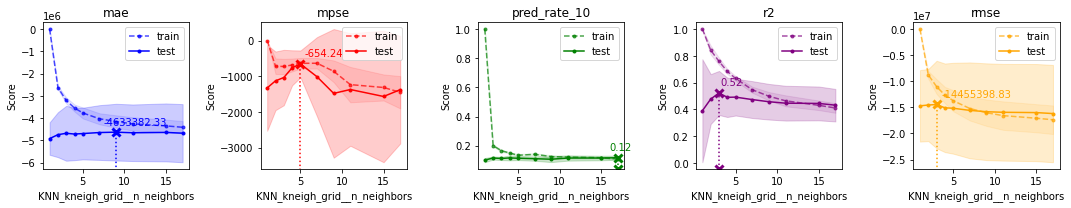

In [69]:
scv = dict_models[name_reg]
plot_scv_multi_scores(name_reg, scv, param = name_reg+'__n_neighbors',
                      title = None, figsize = (15, 3))

The n_neighbor parameter that optimizes r2 score is k=3

Showing influence of both hyperparameters on one the refit_score.

_NB: The score displayed for each cell is the one for the best other parameters_

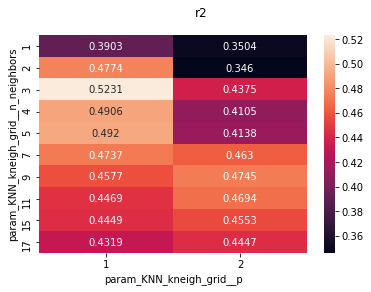

In [70]:
param1 = name_reg+'__'+'n_neighbors'
param2 = name_reg+'__'+'p'
params = [param1, param2]

plot_2D_hyperparam_opt(scv=dict_models[name_reg], params=params,
                       score = 'r2')

The best minkowski metric for the distance is Manhattan (1).

Plotting the learning curve of the best estimator (with r2 score)

-----Learning curve already exists - taking existing learning curve


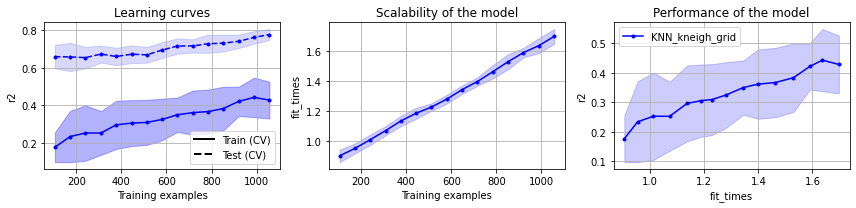

In [71]:
# del dict_lcurves[name_reg] # to overwrite an existing learning curve
cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=0)
fig, axes = plt.subplots(1, 3, figsize=(12, 3));
# title = f"Learning Curves ({name_reg})"
model = dict_models[name_reg].best_estimator_
plot_learning_curve(name_reg, model, dict_scv_params['X'], dict_scv_params['y'], #ylim=(0.7, 1.01),
                    cv=cv, scoring=r2, score_name='r2', #n_jobs=4,
                    file_name=l_curves_file_name,
                    dict_learn_curves=dict_lcurves,
                    train_sizes = np.linspace(0.1,1,15),
                    c='b', axes=axes, title=None)
plt.show()

#### Choosing to fit log y or y ?

In [72]:
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsRegressor
from sklearn.feature_selection import SelectKBest, mutual_info_regression, f_regression

reg = KNeighborsRegressor()
name_reg = 'KNN_log_kneigh_grid'
# del dict_models[name_reg] # to overwrite an existing model
param_grid={'preproc__cust_trans__strat_binary': ['ord'],
            'preproc__cust_trans__strat_low_card': ['ohe'], # 'ohe', 'bin', 'ord', 'hash', 'loo'
            'preproc__cust_trans__strat_high_card': ['ohe'], # 'ohe', 'bin', 'ord', 'hash', 'loo'
            'preproc__cust_trans__strat_quant': ['stand'], # 'stand', 'minmax', 'maxabs', 'robust', 'norm', 'quant_uni', 'quant_norm', 'pow'
            name_reg+'__n_neighbors': [1,2,3,4,5,6,7,9,11,15,17], # 1,2,3,5,7,9,11,15,17
            name_reg+'__p': [1,2]} # 1,2
search_strat = 'grid'
n_iter=None
refit_score = 'r2'

preproc_pipe = Pipeline([('cust_trans', CustTransformer(thresh_card=12))])
pipe = Pipeline([('preproc', preproc_pipe),
	             (name_reg, reg)])
dict_scv_params, models_file_name, l_curves_file_name = \
        set_dict_scv_params(y_tr, y_te, 'SEU', log_on=True, refit=refit_score)

df_res = run_optimization(name_reg, reg, param_grid, models_file_name, dict_models,
                          pipe, dict_scv_params, skf, df_res, search_strat, n_iter)
'''-----Model not existing - computing...
Grid
Fitting 5 folds for each of 22 candidates, totalling 110 fits
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 110 out of 110 | elapsed:  4.8min finished
-----...model dumped'''

-----Model already exists - taking existing model


'-----Model not existing - computing...\nGrid\nFitting 5 folds for each of 22 candidates, totalling 110 fits\n[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.\n[Parallel(n_jobs=1)]: Done 110 out of 110 | elapsed:  4.8min finished\n-----...model dumped'

In [73]:
dict_models[name_reg].best_params_

{'KNN_log_kneigh_grid__n_neighbors': 2,
 'KNN_log_kneigh_grid__p': 1,
 'preproc__cust_trans__strat_binary': 'ord',
 'preproc__cust_trans__strat_high_card': 'ohe',
 'preproc__cust_trans__strat_low_card': 'ohe',
 'preproc__cust_trans__strat_quant': 'stand'}

Showing the different scores vs n_neighbors hyperparameter (other parameters set to best parameters)

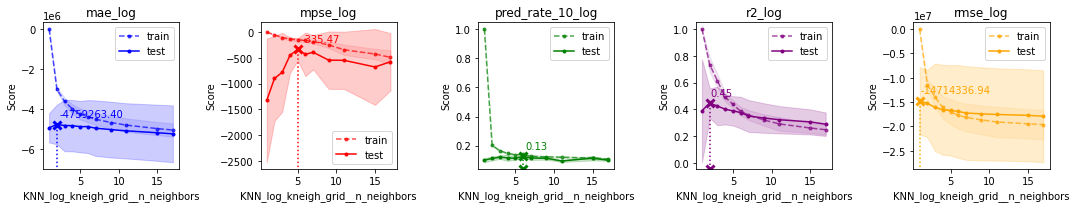

In [74]:
scv = dict_models[name_reg]
plot_scv_multi_scores(name_reg, scv, param = name_reg+'__n_neighbors',
                      title = None, figsize = (15, 3))

The best parameter for pred_rate_10 is k=5

Showing influence of both hyperparameters on one the refit_score.

_NB: The score displayed for each cell is the one for the best other parameters_

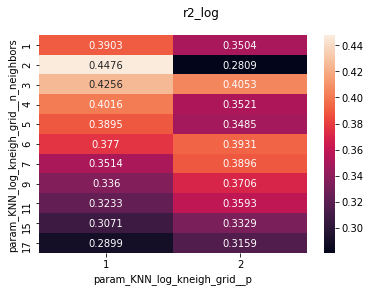

In [75]:
param1 = name_reg+'__'+'n_neighbors'
param2 = name_reg+'__'+'p'
params = [param1, param2]

plot_2D_hyperparam_opt(scv=dict_models[name_reg], params=params,
                       score = 'r2_log')

The best minkowski metric for the distance is Manhattan (1).

Plotting the learning curve of the best estimator (with r2 score)

-----Learning curve already exists - taking existing learning curve


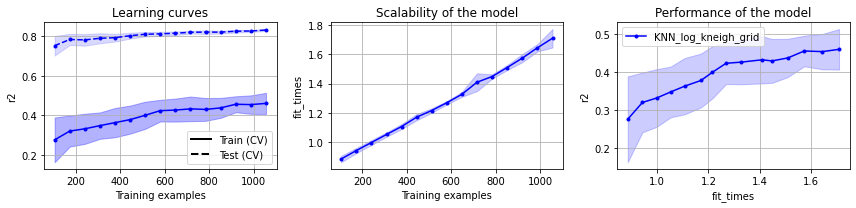

In [76]:
# del dict_lcurves[name_reg] # to overwrite an existing learning curve
cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=0)
fig, axes = plt.subplots(1, 3, figsize=(12, 3));
# title = f"Learning Curves ({name_reg})"
model = dict_models[name_reg].best_estimator_
plot_learning_curve(name_reg, model, dict_scv_params['X'], dict_scv_params['y'], #ylim=(0.7, 1.01),
                    cv=cv, scoring=r2, score_name='r2', #n_jobs=4,
                    file_name=l_curves_file_name,
                    dict_learn_curves=dict_lcurves,
                    train_sizes = np.linspace(0.1,1,15),
                    c='b', axes=axes, title=None)
plt.show()

In [44]:
speak("youpi cé fini !")

#### Feature selection

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsRegressor
from sklearn.feature_selection import SelectKBest, mutual_info_regression, f_regression

reg = KNeighborsRegressor()
name_reg = 'KNN_log_kneigh_grid'
param_grid={'preproc__cust_trans__strat_binary': ['ord'],
            'preproc__cust_trans__strat_low_card': ['ohe'], # 'ohe', 'bin', 'ord', 'hash', 'loo'
            'preproc__cust_trans__strat_high_card': ['ohe'], # 'ohe', 'bin', 'ord', 'hash', 'loo'
            'preproc__cust_trans__strat_quant': ['stand'], # 'stand', 'minmax', 'maxabs', 'robust', 'norm', 'quant_uni', 'quant_norm', 'pow'
            'feat_sel__k_best__k': np.arange(25,26),
            'feat_sel__k_best__score_func': [f_regression], #,mutual_info_regression, f_regression
            name_reg+'__n_neighbors': [1,2,3,5,7,9,11,15,17], # 1,2,3,5,7,9,11,15,17
            name_reg+'__p': [1,2]} # 1,2
search_strat = 'grid'
n_iter=None
refit_score = 'r2'

feat_sel_pipe = Pipeline([('k_best', SelectKBest())])
preproc_pipe = Pipeline([('cust_trans', CustTransformer(thresh_card=12))])
pipe = Pipeline([('preproc', preproc_pipe),
	    	     ('feat_sel', feat_sel_pipe),
	             (name_reg, reg)])
dict_scv_params, models_file_name, l_curves_file_name = \
         set_dict_scv_params(y_tr, y_te, 'SEU', log_on=False, refit=refit_score)

df_res = run_optimization(name_reg, reg, param_grid, models_file_name, dict_models,
                          pipe, dict_scv_params, skf, df_res, search_strat, n_iter)

In [ ]:
speak("youpi cé fini")

Showing variations of one score vs. multiple hyperparameters (mean score accross all other parameters)

In [ ]:
scv = dict_models[name_reg]
grid_params = param_grid
params = [name_reg+'__n_neighbors', name_reg+'__p', 'feat_sel__k_best__k']
score=score_refit

plot_hyperparam_tuning(scv, param_grid, params=params,
              score='rmse', pooled_std=True, agg_func = np.mean)

# A CORRIGER

### 2.2 Ridge Regression

In [ ]:
from sklearn.linear_model import Ridge

reg = Ridge()
name_reg = 'Ridge_rand'
param_grid={'preproc__strat_binary': ['ord'],
            'preproc__strat_low_card': ['ohe', 'bin'], # 'ohe', 'bin', 'ord', 'hash', 'loo'
            'preproc__strat_high_card': ['bin', 'ord', 'hash', 'loo'], # 'ohe', 'bin', 'ord', 'hash', 'loo'
            'preproc__strat_quant': ['stand'], # 'stand', 'minmax', 'maxabs', 'robust', 'norm', 'quant_uni', 'quant_norm', 'pow'
            name_reg+'__alpha': st.loguniform(1e-7, 1e7)} # np.logspace(-7,7,20)
search_strat = 'rand'
n_iter=200

df_res = run_optimization(name_reg, reg, param_grid, models_file_name, dict_models,
                          dict_scv_params, df_res, search_strat, n_iter)

### 2.3 Lasso

In [ ]:
from sklearn.linear_model import Lasso

reg = Lasso()
name_reg = 'Lasso_rand'
param_grid={'preproc__strat_binary': ['ord'],
            'preproc__strat_low_card': ['ohe', 'bin'], # 'ohe', 'bin', 'ord', 'hash', 'loo'
            'preproc__strat_high_card': ['bin', 'ord', 'hash', 'loo'], # 'ohe', 'bin', 'ord', 'hash', 'loo'
            'preproc__strat_quant': ['stand'], # 'stand', 'minmax', 'maxabs', 'robust', 'norm', 'quant_uni', 'quant_norm', 'pow'
            name_reg+'__alpha': st.loguniform(1e-7, 1e7)} # np.logspace(-7,7,20)
search_strat = 'rand'
n_iter=200

df_res = run_optimization(name_reg, reg, param_grid, file_name, dict_models,
                          dict_scv_params, df_res, search_strat, n_iter)

### 2.4 ElasticNet

In [ ]:
from sklearn.linear_model import ElasticNet

reg = ElasticNet()
name_reg = 'ElasticNet_rand'
param_grid={'preproc__strat_binary': ['ord'],
            'preproc__strat_low_card': ['ohe', 'bin'], # 'ohe', 'bin', 'ord', 'hash', 'loo'
            'preproc__strat_high_card': ['ord', 'hash', 'loo'], # 'ohe', 'bin', 'ord', 'hash', 'loo'
            'preproc__strat_quant': ['stand'], # 'stand', 'minmax', 'maxabs', 'robust', 'norm', 'quant_uni', 'quant_norm', 'pow'
            name_reg+'__alpha': st.loguniform(1e-7, 1e7), # np.logspace(-7,7,20)
            name_reg+'__l1_ratio': st.uniform(0,1), # [0,0.15,0.3,0.45,0.6,0.75,1]
            name_reg+'__tol' : st.loguniform(1e-3, 1e0)} #np.logspace(-4,0,5)}
search_strat = 'rand'
n_iter=200

df_res = run_optimization(name_reg, reg, param_grid, models_file_name, dict_models,
                          dict_scv_params, df_res, search_strat, n_iter)

### 2.5 Random Forest Regressor

In [ ]:
from sklearn.ensemble import RandomForestRegressor

reg = RandomForestRegressor()
name_reg = 'RandomForest_grid'
param_grid={'preproc__strat_binary': ['ord'],
            'preproc__strat_low_card': ['ohe', 'bin', 'hash'], # 'ohe', 'bin', 'ord', 'hash', 'loo'
            'preproc__strat_high_card': ['ord', 'hash', 'loo'], # 'ohe', 'bin', 'ord', 'hash', 'loo'
            'preproc__strat_quant': ['stand'], # 'stand', 'minmax', 'maxabs', 'robust', 'norm', 'quant_uni', 'quant_norm', 'pow'
            name_reg+'__n_estimators': [100,200,500],#,200,500,1000], # nb leaves
            name_reg+'__min_samples_leaf': [1,2,5,10], # mean nb leaves in a node
            name_reg+'__max_features': ['auto', 'sqrt']}#, 'sqrt']} # 'auto', 'sqrt' (nb features in a tree)
search_strat = 'grid'

df_res = run_optimization(name_reg, reg, param_grid, models_file_name, dict_models,
                          dict_scv_params, df_res, search_strat, n_iter)

### 2.6 Support Vector Machine Regression

In [ ]:
from sklearn.svm import SVR

reg = SVR()
name_reg = 'SVR_grid'
param_grid={'preproc__strat_binary': ['ord'],
            'preproc__strat_low_card': ['ohe'], # 'ohe', 'bin', 'ord', 'hash', 'loo'
            'preproc__strat_high_card': ['ord', 'loo'], # 'ohe', 'bin', 'ord', 'hash', 'loo'
            'preproc__strat_quant': ['stand'], # 'stand', 'minmax', 'maxabs', 'robust', 'norm', 'quant_uni', 'quant_norm', 'pow'
            name_reg+'__kernel': ['rbf', 'linear', 'poly'], # kernel coef (radial basis function 'rbf')
            name_reg+'__gamma': ['auto'], # np.logspace(-8,0,9), # kernel coef (radial basis function 'rbf')
            name_reg+'__epsilon': np.logspace(-3,0,5), # accepted error
            name_reg+'__C': np.logspace(-2,2,5)} # regularization coef
search_strat = 'grid'

df_res = run_optimization(name_reg, reg, param_grid, models_file_name, dict_models,
                          dict_scv_params, df_res, search_strat, n_iter)

### 2.7 XGBoost Regressor

In [ ]:
from xgboost import XGBRegressor

reg = XGBRegressor(objective ='reg:squarederror')# 'reg:lineaqr' deprecated
name_reg = 'XGBR_grid'
param_grid={'preproc__strat_binary': ['ord'],
            'preproc__strat_low_card': ['ohe', 'bin', 'hash'], # 'ohe', 'bin', 'ord', 'hash', 'loo'
            'preproc__strat_high_card': ['ord', 'hash', 'loo'], # 'ohe', 'bin', 'ord', 'hash', 'loo'
            'preproc__strat_quant': ['stand'], # 'stand', 'minmax', 'maxabs', 'robust', 'norm', 'quant_uni', 'quant_norm', 'pow'
            name_reg+'__learning_rate': np.logspace(-3,-1,3),
            name_reg+'__n_estimators': [1000,2000], # [100,200,500,1000,2000]
            name_reg+'__max_depth': [3,4],
            name_reg+'__subsample': [0.8,1],
            name_reg+'__colsample_bytree': [0.3,0.8,1], # [0.3,0.5,0.8,0.9,1]
            name_reg+'__gamma': [1]}
search_strat = 'grid'

df_res = run_optimization(name_reg, reg, param_grid, models_file_name, dict_models,
                          dict_scv_params, df_res, search_strat, n_iter)

## 3 Comparison of the models
Plotting the main metrics of the optimized models obtained during SearchCV fitting (training/test folds)

In [ ]:
# dict_models_log_SEU = dict_models.copy()
# df_res_log_SEU = df_res.copy('deep')

In [ ]:
# dict_models_SEU = dict_models.copy()
# df_res_SEU = df_res.copy('deep')

In [ ]:
truc2 = df_res_log_SEU.loc[['mean_train_rev_log1p_neg_rmse', 'mean_test_rev_log1p_r2']]

In [ ]:
truc1 = df_res_SEU.loc[['mean_train_neg_root_mean_squared_error',  'mean_test_r2']]

In [ ]:
df_res_SEU.iloc[11]

In [ ]:
p = np.arange(0, 7, 1)
w = 0.4
fig, axs = plt.subplots(1,2, sharey=True)
for d, ax, t in zip([df_res_SEU, df_res_log_SEU], axs, ['SEU', 'log_SEU']):
    ax.bar(p, d.iloc[5], width=w, color= 'b',alpha = 0.5, label='train')
    ax.bar(p+w, d.iloc[11], width=w, color= 'b', label='test')
    ax.set_title(t)
    ax.set_ylabel('R²')
    ax.set_xticks(p+w/2);
    ax.set_xticklabels(d.columns)
    plt.setp(ax.xaxis.get_majorticklabels(), rotation=45, ha="right" )
    ax.legend()
fig.set_size_inches(10,3)

Boucle pour learning curves

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(12, 3));

colors = sns.color_palette("dark", 10)
for name_reg, c in zip(dict_models.keys(), colors):
    # title = f"Learning Curves ({name_reg})"
    model = dict_models[name_reg].best_estimator_
    plot_learning_curve(model, X_tr, y_mod_tr, #ylim=(0.7, 1.01),
                        cv=cv, scoring = make_scorer(calc_pred_rate_10),#n_jobs=4,
                        train_sizes = np.linspace(0.1,1,2),
                        c=c, axes=None)
plt.show()

In [ ]:
plt.show()

In [ ]:
speak("youpi cé fini")